# Text Classification - Deep Learning CNN Models


In [1]:
# Import & inastalling packages

!pip install contractions
!pip install textsearch
!pip install tqdm

# Load python modules
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import model_selection
import seaborn as sns
import re
import contractions
from bs4 import BeautifulSoup
import tqdm
import unicodedata

#nltk libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

#sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics 
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

#Tensorflow layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

     |████████████████████████████████| 287 kB 5.2 MB/s 
     |████████████████████████████████| 106 kB 48.3 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# 1.Exploratory Data Analyis

### Load Amazon Review Dataset

In [2]:
df = pd.read_csv('processed_reviews_split_surnamesPQ_minimal.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32917 entries, 0 to 32916
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         32917 non-null  object 
 1   text              32905 non-null  object 
 2   verified          32802 non-null  object 
 3   review_score      32917 non-null  float64
 4   product_category  32011 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [3]:
#Label distributions - excluded & reason for exclusion
df['excluded'] = df.isna().sum(axis=1).apply(lambda x: 1 if x == 0 else 0)
df['reason_for_exclusion'] = df.isnull().sum(axis=1).apply(lambda x: 'Missing values' if x == 0  else 'N/A')

m1 =  df.duplicated(['text'])   
df['reason_for_exclusion'] = np.select([m1],['duplicated'], default='N/A')

df.insert(len(df.columns)-6, 'excluded', df.pop('excluded'))
df.insert(len(df.columns)-5, 'reason_for_exclusion', df.pop('reason_for_exclusion')) 

In [4]:
df

,review_id,excluded,reason_for_exclusion,text,verified,review_score,product_category
0,product_review_000000,1,N/A,Works as described. Nice combo tool.. Nice co...,True,4.0,musical_instruments
1,product_review_000001,1,N/A,"I used this after using a ""straight"" bridge. T...",True,5.0,musical_instruments
2,product_review_000002,1,N/A,At first I was very hesitant about this game. ...,False,5.0,video_games
3,product_review_000003,1,N/A,great reverb pedal. great addition to my pedal...,True,5.0,musical_instruments
4,product_review_000004,1,N/A,Five stars. Good deal a must buy,True,5.0,video_games
...,...,...,...,...,...,...,...
32912,product_review_032912,0,duplicated,This game is one of my favorites. I found the...,False,5.0,NaN
32913,product_review_032913,1,N/A,Came in the box. No complaints.. Good!,True,5.0,video_games
32914,product_review_032914,1,N/A,First off - it has knobs. I like knobs. Easy t...,False,5.0,musical_instruments
32915,product_review_032915,1,N/A,These are 100% exactly as represented. Great ...,True,5.0,musical_instruments


In [5]:
df['reason_for_exclusion'].unique()

array(['N/A', 'duplicated'], dtype=object)

In [6]:

df.to_csv('exclusions_dataset_task4.csv')

In [7]:
# View the data
df.head()

,review_id,excluded,reason_for_exclusion,text,verified,review_score,product_category
0,product_review_000000,1,N/A,Works as described. Nice combo tool.. Nice co...,True,4.0,musical_instruments
1,product_review_000001,1,N/A,"I used this after using a ""straight"" bridge. T...",True,5.0,musical_instruments
2,product_review_000002,1,N/A,At first I was very hesitant about this game. ...,False,5.0,video_games
3,product_review_000003,1,N/A,great reverb pedal. great addition to my pedal...,True,5.0,musical_instruments
4,product_review_000004,1,N/A,Five stars. Good deal a must buy,True,5.0,video_games


In [8]:
dataset = df[['text','review_score','product_category']]

In [9]:
dataset

,text,review_score,product_category
0,Works as described. Nice combo tool.. Nice co...,4.0,musical_instruments
1,"I used this after using a ""straight"" bridge. T...",5.0,musical_instruments
2,At first I was very hesitant about this game. ...,5.0,video_games
3,great reverb pedal. great addition to my pedal...,5.0,musical_instruments
4,Five stars. Good deal a must buy,5.0,video_games
...,...,...,...
32912,This game is one of my favorites. I found the...,5.0,NaN
32913,Came in the box. No complaints.. Good!,5.0,video_games
32914,First off - it has knobs. I like knobs. Easy t...,5.0,musical_instruments
32915,These are 100% exactly as represented. Great ...,5.0,musical_instruments


# 2.Data Cleaning

In [10]:
# checking for any duplicates in the text columns
dataset['text'].duplicated().sum()

2761

In [11]:
dataset=dataset.drop_duplicates('text', keep='first')
dataset.shape

(30156, 3)

In [12]:
dataset = dataset[dataset.text.notnull()]
dataset.shape

(30155, 3)

In [13]:
dataset=dataset[dataset.product_category.notnull()]
dataset.shape

(29700, 3)

In [14]:
dataset=dataset[dataset.review_score.notnull()]
dataset.shape

(29700, 3)

In [15]:
dataset.isnull().sum()

text                0
review_score        0
product_category    0
dtype: int64

In [16]:
dataset['review_score'] = dataset['review_score'].replace([-1.0],1.0)

In [17]:
dataset['review_score']=dataset['review_score'].astype(int)

In [18]:
dataset['review_score'].unique()

array([4, 5, 1, 3, 2])

## 3.Data Splitting

In [19]:
# build train and test datasets
text = dataset['text'].values
category = dataset['product_category'].values

train_text = text[:20800]
train_category = category[:20800]

test_text = text[20800:]
test_category = category[20800:]

### 3.1 Text Wrangling & Normalization - Text Prcoessing

In [20]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [21]:
%%time
norm_train_text = pre_process_corpus(train_text)
norm_test_text = pre_process_corpus(test_text)
text = pre_process_corpus(text)

100%|██████████| 29700/29700 [00:20<00:00, 1442.90it/s]

CPU times: user 26.1 s, sys: 859 ms, total: 26.9 s
Wall time: 37.3 s


In [22]:
dataset['cleantext'] = text

In [23]:
#After preprocesing
dataset.isnull().sum()

text                0
review_score        0
product_category    0
cleantext           0
dtype: int64

In [24]:
dataset.dropna(inplace = True)

## 3.2 Train - Test Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [25]:
#Assign stopwords 
stopwords_list = nltk.corpus.stopwords.words('english')
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [26]:
#preprocess clean text
stop = stopwords.words('english')
stop.append('I')
stop_words = []
dataset['cleantext'] = dataset['cleantext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
dataset.head()

,text,review_score,product_category,cleantext
0,Works as described. Nice combo tool.. Nice co...,4,musical_instruments,works described nice combo tool nice combo tool
1,"I used this after using a ""straight"" bridge. T...",5,musical_instruments,used using straight bridge make third string t...
2,At first I was very hesitant about this game. ...,5,video_games,first hesitant game seemed surface capcom chan...
3,great reverb pedal. great addition to my pedal...,5,musical_instruments,great reverb pedal great addition pedal board ...
4,Five stars. Good deal a must buy,5,video_games,five stars good deal must buy


In [27]:
#Lemmatization
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
lemmatizer = WordNetLemmatizer() 

# lemmatize string 
def lemmatize_word(text): 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    
    return lemmas 

lemmatized_words = dataset.apply(lambda row: lemmatize_word(row['cleantext']),axis=1) 
#text = 'Fun if you havent played any of the games before!. Fun!'
lemmatized_words

0        [work, describe, nice, combo, tool, nice, comb...
1        [use, use, straight, bridge, make, third, stri...
2        [first, hesitant, game, seem, surface, capcom,...
3        [great, reverb, pedal, great, addition, pedal,...
4                      [five, star, good, deal, must, buy]
                               ...                        
32910    [great, ts808, clone, price, can, not, beat, p...
32913                        [come, box, complaints, good]
32914    [first, knobs, like, knobs, easy, tweak, easy,...
32915                [100, exactly, represent, great, buy]
32916    [write, awful, review, pickup, review, strictl...
Length: 29700, dtype: object

In [28]:
#Tokenization
tokenized_words = dataset.apply(lambda row: word_tokenize(row['cleantext']),axis=1)
tokenized_words

0        [works, described, nice, combo, tool, nice, co...
1        [used, using, straight, bridge, make, third, s...
2        [first, hesitant, game, seemed, surface, capco...
3        [great, reverb, pedal, great, addition, pedal,...
4                     [five, stars, good, deal, must, buy]
                               ...                        
32910    [great, ts808, clone, price, can, not, beat, p...
32913                        [came, box, complaints, good]
32914    [first, knobs, like, knobs, easy, tweak, easy,...
32915              [100, exactly, represented, great, buy]
32916    [wrote, awful, review, pickup, review, strictl...
Length: 29700, dtype: object

In [29]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_text)
t.word_index['<PAD>'] = 0

In [30]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('mairo', 54485), ('<PAD>', 0), 1)

In [31]:
train_sequences = t.texts_to_sequences(norm_train_text)

In [32]:
test_sequences = t.texts_to_sequences(norm_test_text)

In [33]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=54486
Number of Documents=20800


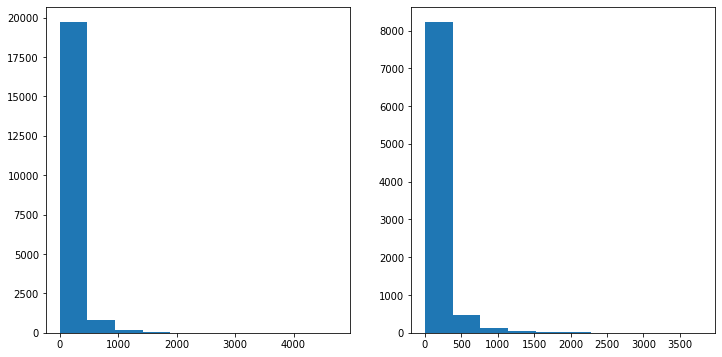

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [35]:
MAX_SEQUENCE_LENGTH = 2000

In [36]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((20800, 2000), (8900, 2000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [37]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [38]:
y_train = le.fit_transform(train_category)
y_test = le.transform(test_category)

In [39]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [40]:
EMBED_SIZE = 300
EPOCHS=3
BATCH_SIZE=128

In [41]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         16345800  
                                                                 
 conv1d (Conv1D)             (None, 2000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1000, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1000, 64)          32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 500, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 500, 32)           8

## Model Training

In [42]:
# Fit the model
history = model.fit(X_train, y_train, 
          validation_split=0.2,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/3
130/130 [==============================] - 50s 299ms/step - loss: 0.2790 - accuracy: 0.8666 - val_loss: 0.1454 - val_accuracy: 0.9332
Epoch 2/3
130/130 [==============================] - 39s 298ms/step - loss: 0.0972 - accuracy: 0.9592 - val_loss: 0.1472 - val_accuracy: 0.9346
Epoch 3/3
130/130 [==============================] - 39s 299ms/step - loss: 0.0578 - accuracy: 0.9769 - val_loss: 0.1628 - val_accuracy: 0.9356


## Model Evaluation

In [43]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

279/279 [==============================] - 8s 27ms/step - loss: 0.1726 - accuracy: 0.9361
Accuracy: 93.61%


In [44]:
predictions = (model.predict(X_test) > 0.5).astype("int32").ravel()
predictions[:10]

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1], dtype=int32)

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['musical_instruments', 'video_games']
print(classification_report(y_test, predictions))
# print(pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels))
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2893
           1       0.96      0.95      0.95      6007

    accuracy                           0.94      8900
   macro avg       0.93      0.93      0.93      8900
weighted avg       0.94      0.94      0.94      8900



array([[2638,  255],
       [ 314, 5693]])

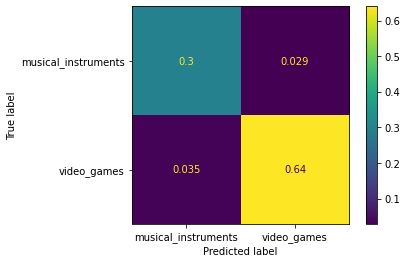

In [46]:
#plotting t
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['musical_instruments', 'video_games'])
cmd.plot()

# Methodology  2

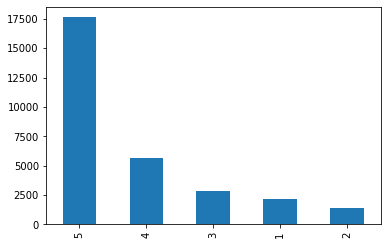

In [47]:
# checking the target distribution
dataset.review_score.value_counts().plot(kind = 'bar')

Spliting the data into train and test sets:

In [48]:
#Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features = 30000, ngram_range = (1,3), analyzer = 'char')
X = vectorizer.fit_transform(dataset['cleantext'])
y = dataset['review_score']

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((20790, 22357), (8910, 22357), (20790,), (8910,))

SVM

In [49]:
#Rclassification
clf = LinearSVC()
clf.fit(X_train,y_train)

from sklearn.metrics import classification_report
clf_predict = clf.predict(X_test)
clf_predict

#Evaluation
print('accuracy is %s' % metrics.accuracy_score(clf_predict, y_test))
print(classification_report(y_test, clf_predict))
print(confusion_matrix(y_test,clf_predict))

accuracy is 0.6368125701459035
              precision    recall  f1-score   support

           1       0.52      0.33      0.40       625
           2       0.31      0.05      0.09       417
           3       0.46      0.17      0.25       895
           4       0.36      0.20      0.26      1701
           5       0.69      0.94      0.80      5272

    accuracy                           0.64      8910
   macro avg       0.47      0.34      0.36      8910
weighted avg       0.57      0.64      0.58      8910

[[ 204   24   28   59  310]
 [  70   22   57   79  189]
 [  63   12  154  234  432]
 [  27    5   62  341 1266]
 [  32    7   34  246 4953]]


Logistic Regression

In [50]:
#LogisticRegressionclassification
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train,y_train)

from sklearn.metrics import classification_report
lgr_predict = clf.predict(X_test)
lgr_predict

#The confusion matrix and classification report(precision, recall, F1-score)
print('accuracy %s' % metrics.accuracy_score(lgr_predict, y_test))
print(classification_report(y_test, lgr_predict))
print(confusion_matrix(y_test,lgr_predict))


accuracy 0.6267115600448934
              precision    recall  f1-score   support

           1       0.59      0.24      0.34       625
           2       0.44      0.01      0.02       417
           3       0.47      0.10      0.16       895
           4       0.36      0.15      0.21      1701
           5       0.66      0.97      0.78      5272

    accuracy                           0.63      8910
   macro avg       0.50      0.29      0.30      8910
weighted avg       0.57      0.63      0.54      8910

[[ 148    0   25   47  405]
 [  43    4   29   73  268]
 [  33    5   86  190  581]
 [   9    0   26  254 1412]
 [  19    0   16  145 5092]]


Naive Bayes Classifier for Multinomial Models

In [51]:
#Naive Bayes
clf = MultinomialNB()
clf.fit(X_train,y_train)

from sklearn.metrics import classification_report
nb_predict = clf.predict(X_test)
nb_predict

#The confusion matrix and classification report(precision, recall, F1-score)
#Evaluation
print('accuracy %s' % metrics.accuracy_score(nb_predict, y_test))
print(classification_report(y_test, nb_predict))
print(confusion_matrix(y_test,nb_predict))

accuracy 0.591358024691358
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       625
           2       0.00      0.00      0.00       417
           3       0.00      0.00      0.00       895
           4       0.00      0.00      0.00      1701
           5       0.59      1.00      0.74      5272

    accuracy                           0.59      8910
   macro avg       0.12      0.20      0.15      8910
weighted avg       0.35      0.59      0.44      8910

[[   0    0    0    0  625]
 [   0    0    0    0  417]
 [   0    0    0    0  895]
 [   0    0    0    0 1701]
 [   2    0    1    0 5269]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest

In [52]:
#Random Forest
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

from sklearn.metrics import classification_report
rf_predict = clf.predict(X_test)
rf_predict

#Evaluation - The confusion matrix and classification report(precision, recall, F1-score)
print('accuracy %s' % metrics.accuracy_score(rf_predict, y_test))
print(classification_report(y_test, rf_predict))
print(confusion_matrix(y_test,rf_predict))

accuracy 0.592929292929293
              precision    recall  f1-score   support

           1       0.25      0.00      0.01       625
           2       0.00      0.00      0.00       417
           3       0.20      0.00      0.00       895
           4       0.38      0.03      0.06      1701
           5       0.60      0.99      0.75      5272

    accuracy                           0.59      8910
   macro avg       0.28      0.21      0.16      8910
weighted avg       0.46      0.59      0.45      8910

[[   3    0    1    6  615]
 [   1    0    1   12  403]
 [   1    1    2   37  854]
 [   1    0    1   58 1641]
 [   6    0    5   41 5220]]


Gradient Boosting

In [53]:
# clf = GradientBoostingClassifier()
# clf.fit(X_train,y_train)

# from sklearn.metrics import classification_report
# grb_predict = clf.predict(X_test)
# grb_predict

# #Evaluation
# print(classification_report(y_test,grb_predict))
# print(metrics.accuracy_score(y_test,grb_predict))
# print(confusion_matrix(y_test,grb_predict))

#Best model

We have tested several different models and now, we check which one is the best:

In [54]:
svm_acc = accuracy_score(y_test,clf_predict)
log_acc = accuracy_score(y_test,lgr_predict)
nb_acc = accuracy_score(y_test,nb_predict)
rf_acc = accuracy_score(y_test,rf_predict)
#gb_acc = accuracy_score(y_test,grb_predict)
#nb_grid_acc = accuracy_score(y_test,clf_predict)

In [55]:
# List the models have tested
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest'],
                      'Score': [log_acc, svm_acc, nb_acc, rf_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,SVM,0.636813
0,Logistic Regression,0.626712
3,Random Forest,0.592929
2,Naive Bayes,0.591358
